In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
import pickle
#pd.set_option('display.max_colwidth', None)
# !pip install spacy -q
# !python -m spacy download en_core_web_sm -q

In [13]:
complaints_orig = pd.read_csv('../data/complaints.csv')
complaints = complaints_orig
complaints

,Consumer complaint narrative,Issue
0,My name is XXXX XXXX this complaint is not mad...,Incorrect information on your report
1,I searched on XXXX for XXXXXXXX XXXX and was ...,Fraud or scam
2,I have a particular account that is stating th...,Incorrect information on your report
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report
...,...,...
353427,Collections account I have no knowledge of,Attempts to collect debt not owed
353428,"Dear CFPB Team, The reason for my complaint is...",Attempts to collect debt not owed
353429,FRCA violations : Failing to Follow Debt Dispu...,Attempts to collect debt not owed
353430,"My Father, a XXXX XXXX acquired an HECM rever...",Struggling to pay mortgage


# Cleanup

In [14]:
#rename the column
complaints = complaints.rename(columns={"Consumer complaint narrative": "complaint"})

In [15]:
complaints.Issue.unique()

array(['Incorrect information on your report', 'Fraud or scam',
       'Attempts to collect debt not owed', 'Communication tactics',
       'Struggling to pay mortgage'], dtype=object)

In [16]:
complaints_ORIG =complaints

In [17]:
complaints_cleaned =complaints

# Option 1 Cleanup - clean_text

In [18]:
import string
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
REPLACE_XX = re.compile('XX(X+|[/.])')
REPLACE_NUMBERS = re.compile('[0-9]')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = REPLACE_XX.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = REPLACE_NUMBERS.sub('', text) # delete numbers which are in REPLACE_NUMBERS from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    


In [19]:
#Call the clean_text function
complaints['comp_cleaned'] = complaints['complaint'].apply(clean_text)

In [20]:
complaints.Issue.value_counts()

Issue
Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: count, dtype: int64

In [21]:
# PerctOfRows = 0.1
# #@sampled_df = complaints[complaints['Issue'] == 'Incorrect information on your report'].sample(frac=PerctOfRows)
# complaints_1 = complaints[complaints['Issue'] == 'Incorrect information on your report'].sample(frac=PerctOfRows)
# complaints_2 = complaints[complaints['Issue'] == 'Attempts to collect debt not owed'].sample(frac=PerctOfRows)
# complaints_3 = complaints[complaints['Issue'] == 'Communication tactics'].sample(frac=PerctOfRows)
# complaints_4 = complaints[complaints['Issue'] == 'Struggling to pay mortgage'].sample(frac=PerctOfRows)
# complaints_5 = complaints[complaints['Issue'] == 'Fraud or scam'].sample(frac=PerctOfRows)

In [22]:
# frames = [complaints_1, complaints_2, complaints_3, complaints_4, complaints_5  ]
# complaints = pd.concat(frames)
#complaints

In [23]:
# complaints['category_id'] = complaints['Issue'].factorize()[0]
# category_id_df = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'Issue']].values)
# complaints

In [24]:
# from sklearn.utils import shuffle
# complaints = shuffle(complaints)
# complaints


In [25]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(complaints.comp_cleaned).toarray()
# labels = complaints.category_id
# features.shape

In [26]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 10
# for Issue, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names_out())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   #Trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
#   print("# '{}':".format(Issue))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
#   #print("  . Most correlated Trigrams:\n. {}".format('\n. '.join(Trigrams[-N:])))

# Function pretty_conf_matrix

In [27]:
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# df_labels_unique = dataframe unique label values
#cmap_color_pl - sns color pallete e.g. "Blues", "Reds"
# title - string Title
def pretty_conf_matrix(cf_matrix, df_labels_unique, cmap_color_pl, title) : 
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)


    ax = sns.heatmap(cf_matrix, annot=True, square= True, cmap='Blues', cbar=False, fmt='d', xticklabels=df_labels_unique,
                     yticklabels=df_labels_unique )
    

    # set x-axis label and ticks. 
    #ax.set_xlabel("Predicted ", fontsize=14, labelpad=20)
    #ax.xaxis.set_ticklabels(['Negative', 'Positive'])

    # set y-axis label and ticks
    #ax.set_ylabel("Actual ", fontsize=14, labelpad=20)
    #ax.yaxis.set_ticklabels(['Negative', 'Positive'])

    ax.set_yticklabels(ax.get_yticklabels(), va='center')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # set plot title
    ax.set_title(title, fontsize=14, pad=20)

    plt.show()

## Top words in each issue Category

In [28]:
def GetTopWordsbyIssue(df, itemIssue):
    import nltk
    import pandas as pd
    from nltk.corpus import stopwords
    from collections import Counter

    # Load the dataframe
    df = df[df['Issue'] == itemIssue]

    # Define the stop words to exclude
    stop_words = set(stopwords.words('english'))

    # Tokenize the category column and exclude stopwords
    category_words = [word.lower() for word in nltk.word_tokenize(df['comp_cleaned'].str.cat(sep=' ')) if word.lower() not in stop_words]
    category_words
    # Retrieve the top 100 most common words
    top_words = Counter(category_words).most_common(100)
    top_words=pd.DataFrame(top_words, columns=['word','count']).sort_values(by=['count'] ,ascending=False)
    print( itemIssue + " - Top words")
    print(top_words)
    return top_words

In [29]:
#C1 = GetTopWordsbyIssue(complaints,'Incorrect information on your report')

In [30]:
#C2 =GetTopWordsbyIssue(complaints,'Attempts to collect debt not owed')

In [31]:
#C3 = GetTopWordsbyIssue(complaints,'Communication tactics')

In [32]:
#C4 = GetTopWordsbyIssue(complaints,'Struggling to pay mortgage')

In [33]:
#C5 = GetTopWordsbyIssue(complaints,'Fraud or scam')

# Models

## 1 - Model - LogisticRegression

C:\Users\kalea\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.77      0.65      0.70     14633
               Communication tactics       0.82      0.76      0.79      4249
                       Fraud or scam       0.93      0.85      0.89      2469
Incorrect information on your report       0.89      0.95      0.92     45861
          Struggling to pay mortgage       0.93      0.89      0.91      3475

                            accuracy                           0.87     70687
                           macro avg       0.87      0.82      0.84     70687
                        weighted avg       0.87      0.87      0.87     70687



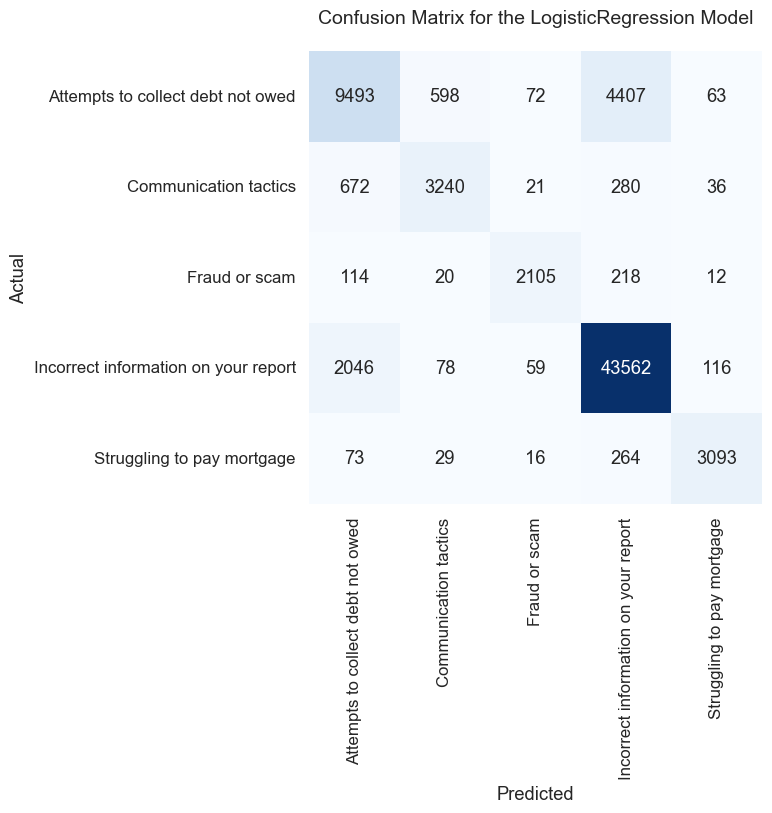

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = complaints['comp_cleaned']
y = complaints['Issue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

logreg  = LogisticRegression()
logreg.fit(X_train_vec, y_train)

y_pred = logreg.predict(X_test_vec)
print(classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)

pretty_conf_matrix(cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the LogisticRegression Model")

#1 save the model to disk
# filename = 'A_LogReg_model.pickle'
# pickle.dump(logreg, open(filename, 'wb'))


# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)


<AxesSubplot:>

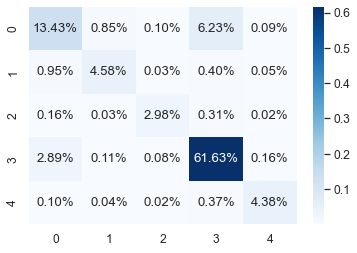

In [35]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

 # Model 2  LinearSVC
 ngram_range=(1, 2)

                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.81      0.76      0.78     18412
               Communication tactics       0.84      0.77      0.81      5257
                       Fraud or scam       0.94      0.89      0.92      3122
Incorrect information on your report       0.93      0.96      0.94     57230
          Struggling to pay mortgage       0.94      0.94      0.94      4337

                            accuracy                           0.90     88358
                           macro avg       0.89      0.86      0.88     88358
                        weighted avg       0.90      0.90      0.90     88358

[[13962   634    82  3656    78]
 [  938  4059    23   214    23]
 [  101    22  2782   208     9]
 [ 2171    67    53 54807   132]
 [   52    33     7   168  4077]]


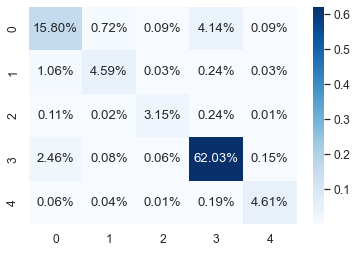

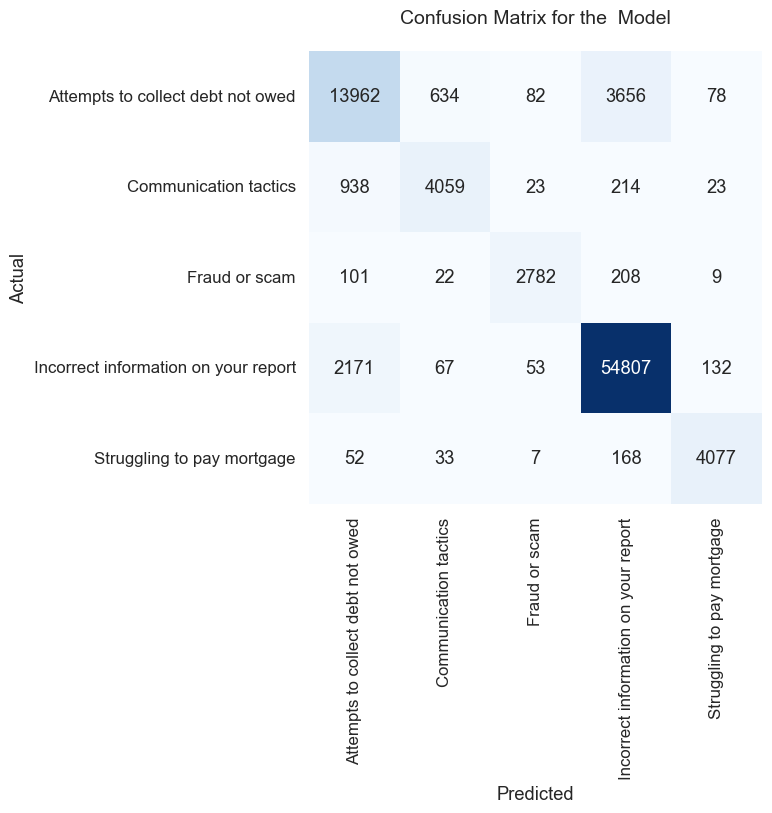

In [37]:
from sklearn.svm import LinearSVC
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = LinearSVC()
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# #1 save the model to disk
filename = 'A_LinSVC_model_ng_1_2.pickle'
pickle.dump(svc, open(filename, 'wb'))


# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)

import seaborn as sns
sns.heatmap(svc_cf_matrix/np.sum(svc_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")



In [ ]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
#                         ngram_range=(1, 2), 
#                         stop_words='english')

# # We transform each complaint into a vector
# features = tfidf.fit_transform(complaints['complaint']).toarray()

# labels = complaints.Issue

# print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

In [ ]:
# import string

# # punctuations
# punctuations=list(string.punctuation)
# punctuations

# Model 3  LinearSVC
 ngram_range=(1, 3)

                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.82      0.77      0.79     18412
               Communication tactics       0.84      0.77      0.81      5257
                       Fraud or scam       0.94      0.89      0.92      3122
Incorrect information on your report       0.93      0.96      0.94     57230
          Struggling to pay mortgage       0.94      0.94      0.94      4337

                            accuracy                           0.90     88358
                           macro avg       0.89      0.87      0.88     88358
                        weighted avg       0.90      0.90      0.90     88358

[[14104   646    88  3495    79]
 [  917  4073    23   222    22]
 [   94    22  2786   211     9]
 [ 2120    66    57 54849   138]
 [   50    34     7   160  4086]]


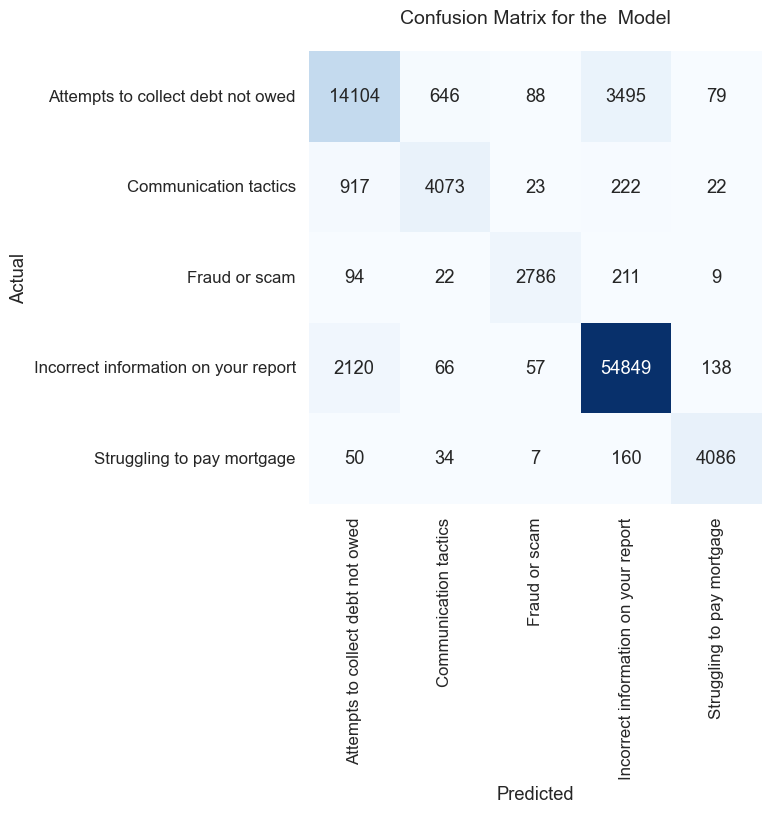

In [13]:
from sklearn.svm import LinearSVC
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = LinearSVC()
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# #1 save the model to disk
filename = 'A_LinSVC_model_ng_1_3.pickle'
pickle.dump(svc, open(filename, 'wb'))


# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)
pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

# Model 4 - SVC
ngram_range=(1, 3)

In [ ]:
from sklearn.svm import SVC
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = SVC()
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# #1 save the model to disk
filename = 'P_SVC_model_ng_1_3.pickle'
pickle.dump(svc, open(filename, 'wb'))

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)

pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)



# Model 5 - SVC -2
ngram_range=(1, 2)
kernel = 'linear'

In [ ]:
from sklearn.svm import SVC
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = SVC(kernel = 'linear', C = 1)
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)

pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

# #1 save the model to disk
filename = 'A_SVC_model_Ker-Linear_ng_1_2.pickle'
pickle.dump(svc, open(filename, 'wb'))


# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)



#  Model SVC - 6
ngram_range=(1, 2)
kernel = 'poly'

In [ ]:
from sklearn.svm import SVC
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = SVC(kernel = 'poly', C = 1)
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)

pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

#1 save the model to disk
filename = 'A_SVC_model_Ker-Poly_ng_1_2.pickle'
pickle.dump(svc, open(filename, 'wb'))

import seaborn as sns
sns.heatmap(svc_cf_matrix/np.sum(svc_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)


# Model 7 - SVC - 2
ngram_range=(1, 2)
kernel = 'rbf'

In [ ]:
from sklearn.svm import SVC
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = SVC(kernel = 'rbf', C = 1)
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)

pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

import seaborn as sns
sns.heatmap(svc_cf_matrix/np.sum(svc_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')


#1 save the model to disk
filename = 'A_SVC_model_Ker-rbf_ng_1_2.pickle'
pickle.dump(svc, open(filename, 'wb'))


# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)

# 8 -  RandomForestClassifier

In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
X = complaints['comp_cleaned']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)

svc = RandomForestClassifier()
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

svc_cf_matrix = confusion_matrix(y_test, y_pred)
print(svc_cf_matrix)

pretty_conf_matrix(svc_cf_matrix, np.sort(complaints['Issue'].unique()), 'Blues', "Confusion Matrix for the  Model")

import seaborn as sns
sns.heatmap(svc_cf_matrix/np.sum(svc_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#1 save the model to disk
filename = 'P_random_forest_model_ng_1_2.pickle'
pickle.dump(svc, open(filename, 'wb'))


# #2 load model
# loaded_model = pickle.load(open(filename, "rb"))

# #3 you can use loaded model to compute predictions
# result = loaded_model.score(X_test, y_test)
# y_predicted = loaded_model.predict(X)
# print(result)

                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.83      0.67      0.74     18412
               Communication tactics       0.86      0.66      0.75      5257
                       Fraud or scam       0.97      0.76      0.86      3122
Incorrect information on your report       0.89      0.98      0.93     57230
          Struggling to pay mortgage       0.96      0.86      0.91      4337

                            accuracy                           0.88     88358
                           macro avg       0.90      0.79      0.84     88358
                        weighted avg       0.88      0.88      0.88     88358

[[12258   477    34  5568    75]
 [ 1251  3489     8   491    18]
 [  103    25  2387   595    12]
 [ 1180    29    18 55953    50]
 [   55    37     8   494  3743]]


NameError: name 'pretty_conf_matrix' is not defined